# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.

In [1]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

In [2]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [3]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [4]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [5]:
polygon_gdf = gpd.read_file('methow_outline.geojson', crs='epsg:4326')
polygon_gdf.head()

,fn,date,geometry
0,./datasetsA/methow_basin_2018/dtm/raw/methow_b...,2018,"POLYGON ((-120.53051 48.48366, -120.53051 48.4..."
1,./datasetsA/methow_basin_2018/dtm/raw/methow_b...,2018,"POLYGON ((-120.56868 48.39447, -120.56868 48.3..."
2,./datasetsA/methow_basin_2018/dtm/raw/methow_b...,2018,"POLYGON ((-120.11857 48.26665, -120.11857 48.2..."
3,./datasetsA/methow_basin_2018/dtm/raw/methow_b...,2018,"POLYGON ((-120.33042 48.80903, -120.33042 48.8..."


In [6]:
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

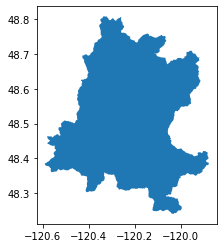

In [8]:
polygon_gdf[0:].plot()

In [9]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(polygon_gdf[0:])
geodata = ipyleaflet.GeoData(geo_dataframe=polygon_gdf[0:])
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [10]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion("methow_outline.geojson")
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [11]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 136513 records


,distance,dh_fit_dx,gt,spot,w_surface_window_final,h_mean,dh_fit_dy,n_fit_photons,pflags,cycle,h_sigma,rgt,rms_misfit,delta_time,segment_id,geometry
time,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,5.382001e+06,0.367318,20,1,9.386548,774.110259,0.0,41,0,1,0.079705,646,0.506044,2.703658e+07,268398,POINT (-120.00053 48.33917)
2018-11-09 22:09:43.789049908,5.382903e+06,0.028568,20,1,3.000000,919.941824,0.0,42,0,1,0.050617,646,0.305572,2.703658e+07,268443,POINT (-120.00167 48.34723)
2018-11-09 22:09:43.794872008,5.382943e+06,-0.116342,20,1,3.029108,918.460968,0.0,31,0,1,0.046853,646,0.240537,2.703658e+07,268445,POINT (-120.00172 48.34760)
2018-11-09 22:09:43.797684372,5.382963e+06,-0.091024,20,1,3.000000,916.399163,0.0,39,0,1,0.059160,646,0.325805,2.703658e+07,268446,POINT (-120.00174 48.34778)
2018-11-09 22:09:43.800494952,5.382983e+06,-0.027886,20,1,3.000000,915.721672,0.0,40,0,1,0.038990,646,0.245902,2.703658e+07,268447,POINT (-120.00177 48.34796)


In [13]:
gdf.to_file('methow_all_sr-atl06_03302022.geojson', driver='GeoJSON')

<AxesSubplot:>

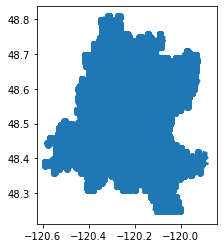

In [15]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
polygon_gdf.plot(ax=ax)